<a href="https://colab.research.google.com/github/thesimaranjaira/AspectExtraction_SentimentAnalysis/blob/main/KNN_Regressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mplt
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from termcolor import colored as cl



/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/My Drive/dataset/data_no1.csv')
print(df.head(10))
print(df.describe(include='all'))

             timestamp  consumption  ...  forecasttotalpulse  homesforecastedpulse
0  2018-08-13 01:00:00     1.167373  ...                 NaN                   NaN
1  2018-08-13 02:00:00     1.171019  ...                 NaN                   NaN
2  2018-08-13 03:00:00     1.102508  ...                 NaN                   NaN
3  2018-08-13 04:00:00     1.281203  ...                 NaN                   NaN
4  2018-08-13 05:00:00     1.562144  ...                 NaN                   NaN
5  2018-08-13 06:00:00     1.401059  ...                 NaN                   NaN
6  2018-08-13 07:00:00     1.229084  ...                 NaN                   NaN
7  2018-08-13 08:00:00     1.124097  ...                 NaN                   NaN
8  2018-08-13 09:00:00     1.095233  ...                 NaN                   NaN
9  2018-08-13 10:00:00     1.076520  ...                 NaN                   NaN

[10 rows x 22 columns]
                  timestamp  ...  homesforecastedpulse
count   

In [4]:
ActualLoad_total = (pd.read_csv("/content/drive/My Drive/dataset/data_no1.csv", index_col=["timestamp"], parse_dates=True).iloc[:, 2]).rename("load")
ForecastedLoad_home= (pd.read_csv("/content/drive/My Drive/dataset/data_no1.csv", index_col=["timestamp"], parse_dates=True).iloc[:, 10]).rename("forecasted_GLM")
tempC = (pd.read_csv("/content/drive/My Drive/dataset/data_no1.csv", index_col=["timestamp"], parse_dates=True).iloc[:, 4])
perHome= (pd.read_csv("/content/drive/My Drive/dataset/data_no1.csv", index_col=["timestamp"], parse_dates=True).iloc[:, 0]).rename("consumption_perHome")

In [5]:
print(ActualLoad_total, ForecastedLoad_home, tempC, perHome)

timestamp
2018-08-13 01:00:00      3190.430
2018-08-13 02:00:00      3200.395
2018-08-13 03:00:00      3013.154
2018-08-13 04:00:00      3501.527
2018-08-13 05:00:00      4269.340
                          ...    
2021-01-28 18:00:00    180122.345
2021-01-28 19:00:00    180508.608
2021-01-28 20:00:00    177324.554
2021-01-28 21:00:00    171417.187
2021-01-28 22:00:00    163884.793
Name: load, Length: 21598, dtype: float64 timestamp
2018-08-13 01:00:00    1.281439
2018-08-13 02:00:00    1.273370
2018-08-13 03:00:00    1.247555
2018-08-13 04:00:00    1.311142
2018-08-13 05:00:00    1.426472
                         ...   
2021-01-28 18:00:00    4.443659
2021-01-28 19:00:00    4.397501
2021-01-28 20:00:00    4.306531
2021-01-28 21:00:00    4.154426
2021-01-28 22:00:00    3.940354
Name: forecasted_GLM, Length: 21598, dtype: float64 timestamp
2018-08-13 01:00:00     7.182149
2018-08-13 02:00:00     6.393077
2018-08-13 03:00:00     6.117321
2018-08-13 04:00:00     6.660875
2018-08-13 05:00:0

In [6]:
def get_interactions(s, dummies, poly_degree=1):
    if s.name == None: s.name = "_"
    s1 = dummies.apply(lambda x: x * s).rename("{}".format(s.name + "_{}").format, axis=1)
    s2 = (dummies.apply(lambda x: x * s) **2).rename("{}".format(s.name + "2_{}").format, axis=1)
    s3 = (dummies.apply(lambda x: x * s) **3).rename("{}".format(s.name + "3_{}").format, axis=1)
    
    if poly_degree == 1: s2, s3 = None, None
    if poly_degree == 2: s3 = None

    df = pd.concat([s1, s2, s3], axis=1)
    return df


In [10]:
def get_season(ts_in):
    season = pd.Series()

    for year in ts_in.index.year.unique():

        # CREATE SEASONS
        yearly_season = pd.Series("inter-season", index=ts_in.loc[str(year)].index)

        yearly_season.loc[: "{}-2-15".format(year)] = "winter"
        yearly_season.loc["{}-11-15".format(year) :] = "winter"
        yearly_season.loc["{}-5-15".format(year) : "{}-9-15".format(year)] = "summer"

        season = pd.concat([season, yearly_season])
    return season

In [11]:
y_home= perHome.rename("y_home").copy()

In [13]:
season = get_season(y_home).rename("season")
month = pd.Series(y_home.index.month.astype(str), index=y_home.index, name="month").apply(lambda x: "m{}".format(x))
day = pd.Series(y_home.index.dayofweek.astype(str), index=y_home.index, name="day").apply(lambda x: "d{}".format(x))
hour = pd.Series(y_home.index.strftime("%H:%M"), index=y_home.index, name="hour")
dayhour = (day + "_" + hour).rename("dayhour")

month_dummies = pd.get_dummies(month.sort_values()).sort_index()
day_dummies = pd.get_dummies(day.sort_values()).sort_index()
hour_dummies = pd.get_dummies(hour.sort_values()).sort_index()
dayhour_dummies = pd.get_dummies(dayhour.sort_values()).sort_index()

trend = pd.Series(np.arange(1, len(y_home) + 1), y_home.index, name="trend")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [14]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [32]:
#Hour of the day without dropping dummies
X = hour_dummies.values
y = y_home
#y = y_home.values.reshape(-1, 1)
X_train = X[:int(X.shape[0]*0.8)]
X_test = X[int(X.shape[0]*0.8):]
y_train = y[:int(X.shape[0]*0.8)]
y_test = y[int(X.shape[0]*0.8):]
tscv = TimeSeriesSplit(n_splits=5)
i = 1
score = []
for tr_index, val_index in tscv.split(X_train):
    X_tr, X_val = X_train[tr_index], X_train[val_index]
    y_tr, y_val = y_train[tr_index], y_train[val_index]
    neigh = KNeighborsRegressor(n_neighbors=5)
    neigh.fit(X_tr, y_tr)
    score.append([i, neigh.score(X_val, y_val)])
    i += 1
yhat=pd.Series(neigh.predict(X_test).flatten(), index=y_test.index, name="y_hour")
MAPE= mean_absolute_percentage_error(y_test,yhat)
print(MAPE)
print(score)
y_pred_hour=yhat.copy()

38.837826784282406
[[1, -9.940391930437297], [2, -0.26247304619252065], [3, -0.9373306878382814], [4, -12.065391280977225], [5, -0.5817871407388147]]


In [29]:
#Month+DAY+hour
Xhat = pd.concat([month_dummies.iloc[:, :-1],  
               day_dummies.iloc[:, :-1],   
               hour_dummies.iloc[:, :-1]    
              ], axis=1)
X = Xhat.values
y = y_home
#y = y_home.values.reshape(-1, 1)
X_train = X[:int(X.shape[0]*0.8)]
X_test = X[int(X.shape[0]*0.8):]
y_train = y[:int(X.shape[0]*0.8)]
y_test = y[int(X.shape[0]*0.8):]
tscv = TimeSeriesSplit(n_splits=5)
i = 1
score = []
for tr_index, val_index in tscv.split(X_train):
    X_tr, X_val = X_train[tr_index], X_train[val_index]
    y_tr, y_val = y_train[tr_index], y_train[val_index]
    neigh = KNeighborsRegressor(n_neighbors=5)
    neigh.fit(X_tr, y_tr)
    score.append([i, neigh.score(X_val, y_val)])
    i += 1
yhat=pd.Series(neigh.predict(X_test).flatten(), index=y_test.index, name="y_mdh")
MAPE= mean_absolute_percentage_error(y_test,yhat)
print(MAPE)
print(score)
y_pred_mdh = yhat.copy() 

13.61046891866291
[[1, -6.868488989468295], [2, 0.12965194818237968], [3, 0.8747095476838627], [4, -0.2843978655040045], [5, 0.7062598286114579]]


In [22]:
#MONTH + DAY x Hour
X_hat = pd.concat([month_dummies.iloc[:, :-1], 
               dayhour_dummies.iloc[:, :-1],    
              ], axis=1)
X = X_hat.values
y = y_home
#y = y_home.values.reshape(-1, 1)
X_train = X[:int(X.shape[0]*0.8)]
X_test = X[int(X.shape[0]*0.8):]
y_train = y[:int(X.shape[0]*0.8)]
y_test = y[int(X.shape[0]*0.8):]
tscv = TimeSeriesSplit(n_splits=5)
i = 1
score = []
for tr_index, val_index in tscv.split(X_train):
    X_tr, X_val = X_train[tr_index], X_train[val_index]
    y_tr, y_val = y_train[tr_index], y_train[val_index]
    neigh = KNeighborsRegressor(n_neighbors=5)
    neigh.fit(X_tr, y_tr)
    score.append([i, neigh.score(X_val, y_val)])
    i += 1
yhat=pd.Series(neigh.predict(X_test).flatten(), index=y_test.index, name="y_mdxh")
MAPE= mean_absolute_percentage_error(y_test,yhat)
print(MAPE)
print(score)
y_pred_mdxh = yhat.copy() 

13.464380764520993
[[1, -6.885641544531895], [2, 0.14008007981297144], [3, 0.8619711782327266], [4, -0.19899946050248385], [5, 0.7078876498138847]]


In [21]:
#with temp
X_HAT = pd.concat([month_dummies.iloc[:, :-1],  
               dayhour_dummies.iloc[:, :-1],    
               # month interactions
               get_interactions(tempC, month_dummies, poly_degree=3),
               # hourly interactions
               get_interactions(tempC, hour_dummies, poly_degree=3)   
              ], axis=1)
X = X_HAT.values
y = y_home
#y = y_home.values.reshape(-1, 1)
X_train = X[:int(X.shape[0]*0.8)]
X_test = X[int(X.shape[0]*0.8):]
y_train = y[:int(X.shape[0]*0.8)]
y_test = y[int(X.shape[0]*0.8):]
tscv = TimeSeriesSplit(n_splits=5)
i = 1
score = []
for tr_index, val_index in tscv.split(X_train):
    X_tr, X_val = X_train[tr_index], X_train[val_index]
    y_tr, y_val = y_train[tr_index], y_train[val_index]
    neigh = KNeighborsRegressor(n_neighbors=5)
    neigh.fit(X_tr, y_tr)
    score.append([i, neigh.score(X_val, y_val)])
    i += 1
yhat=pd.Series(neigh.predict(X_test).flatten(), index=y_test.index, name="y_temp")
MAPE= mean_absolute_percentage_error(y_test,yhat)
print(MAPE)
print(score)
y_pred_temp = yhat.copy() 

8.512805136221257
[[1, 0.3812451293248428], [2, 0.10934702787125705], [3, 0.908265986074093], [4, 0.29743375628237334], [5, 0.8510339128734313]]


In [35]:
#trend
X_h = pd.concat([month_dummies.iloc[:, :-1],  
               dayhour_dummies.iloc[:, :-1],   
               
               get_interactions(tempC, month_dummies, poly_degree=3),  # month interactions
               get_interactions(tempC, hour_dummies, poly_degree=3),   # hourly interactions
               
               trend
              ], axis=1)
X = X_h.values
y = y_home
#y = y_home.values.reshape(-1, 1)
X_train = X[:int(X.shape[0]*0.8)]
X_test = X[int(X.shape[0]*0.8):]
y_train = y[:int(X.shape[0]*0.8)]
y_test = y[int(X.shape[0]*0.8):]
tscv = TimeSeriesSplit(n_splits=5)
i = 1
score = []
for tr_index, val_index in tscv.split(X_train):
    X_tr, X_val = X_train[tr_index], X_train[val_index]
    y_tr, y_val = y_train[tr_index], y_train[val_index]
    neigh = KNeighborsRegressor(n_neighbors=5)
    neigh.fit(X_tr, y_tr)
    score.append([i, neigh.score(X_val, y_val)])
    i += 1
yhat=pd.Series(neigh.predict(X_test).flatten(), index=y_test.index, name="y_trend")
MAPE= mean_absolute_percentage_error(y_test,yhat)
print(MAPE)
print(score)
y_pred_trend = yhat.copy() 

39.22527641042084
[[1, -0.02478682105670038], [2, -3.735045846688295], [3, -2.159342433826793], [4, -0.18838641049598448], [5, -2.7734843530245623]]


In [34]:
#trend+temp
X_h = pd.concat([month_dummies.iloc[:, :-1],  
               dayhour_dummies.iloc[:, :-1],   
               
               get_interactions(tempC, month_dummies, poly_degree=3),  # month interactions
               get_interactions(tempC, hour_dummies, poly_degree=3),   # hourly interactions
               
               tempC
              ], axis=1)
X = X_h.values
y = y_home
#y = y_home.values.reshape(-1, 1)
X_train = X[:int(X.shape[0]*0.8)]
X_test = X[int(X.shape[0]*0.8):]
y_train = y[:int(X.shape[0]*0.8)]
y_test = y[int(X.shape[0]*0.8):]
tscv = TimeSeriesSplit(n_splits=5)
i = 1
score = []
for tr_index, val_index in tscv.split(X_train):
    X_tr, X_val = X_train[tr_index], X_train[val_index]
    y_tr, y_val = y_train[tr_index], y_train[val_index]
    neigh = KNeighborsRegressor(n_neighbors=5)
    neigh.fit(X_tr, y_tr)
    score.append([i, neigh.score(X_val, y_val)])
    i += 1
yhat=pd.Series(neigh.predict(X_test).flatten(), index=y_test.index, name="y_tempC")
MAPE= mean_absolute_percentage_error(y_test,yhat)
print(MAPE)
print(score)
y_pred_tempC = yhat.copy() 

8.559391148628984
[[1, 0.4223607629052051], [2, 0.10856801626453684], [3, 0.9076991218681377], [4, 0.2861844856957062], [5, 0.849902762343635]]


In [36]:
#MONTH + DAY x Hour + tempC
X_hat = pd.concat([month_dummies.iloc[:, :-1], 
               dayhour_dummies.iloc[:, :-1],
               tempC    
              ], axis=1)
X = X_hat.values
y = y_home
#y = y_home.values.reshape(-1, 1)
X_train = X[:int(X.shape[0]*0.8)]
X_test = X[int(X.shape[0]*0.8):]
y_train = y[:int(X.shape[0]*0.8)]
y_test = y[int(X.shape[0]*0.8):]
tscv = TimeSeriesSplit(n_splits=5)
i = 1
score = []
for tr_index, val_index in tscv.split(X_train):
    X_tr, X_val = X_train[tr_index], X_train[val_index]
    y_tr, y_val = y_train[tr_index], y_train[val_index]
    neigh = KNeighborsRegressor(n_neighbors=5)
    neigh.fit(X_tr, y_tr)
    score.append([i, neigh.score(X_val, y_val)])
    i += 1
yhat=pd.Series(neigh.predict(X_test).flatten(), index=y_test.index, name="y_mdxh_tempC")
MAPE= mean_absolute_percentage_error(y_test,yhat)
print(MAPE)
print(score)
y_pred_mdxh_tempC = yhat.copy() 

9.859984170640256
[[1, 0.012687001289877653], [2, 0.39309639120864925], [3, 0.8500485814428618], [4, 0.1278409281056525], [5, 0.6787278756746996]]


In [37]:
#Month+DAY+hour
Xhat = pd.concat([month_dummies.iloc[:, :-1],  
               day_dummies.iloc[:, :-1],   
               hour_dummies.iloc[:, :-1],
               tempC    
              ], axis=1)
X = Xhat.values
y = y_home
#y = y_home.values.reshape(-1, 1)
X_train = X[:int(X.shape[0]*0.8)]
X_test = X[int(X.shape[0]*0.8):]
y_train = y[:int(X.shape[0]*0.8)]
y_test = y[int(X.shape[0]*0.8):]
tscv = TimeSeriesSplit(n_splits=5)
i = 1
score = []
for tr_index, val_index in tscv.split(X_train):
    X_tr, X_val = X_train[tr_index], X_train[val_index]
    y_tr, y_val = y_train[tr_index], y_train[val_index]
    neigh = KNeighborsRegressor(n_neighbors=5)
    neigh.fit(X_tr, y_tr)
    score.append([i, neigh.score(X_val, y_val)])
    i += 1
yhat=pd.Series(neigh.predict(X_test).flatten(), index=y_test.index, name="y_mdh_tempC")
MAPE= mean_absolute_percentage_error(y_test,yhat)
print(MAPE)
print(score)
y_pred_mdh_tempC = yhat.copy() 

8.910207938575093
[[1, 0.4547336303343711], [2, 0.4135641598339547], [3, 0.8902461129127354], [4, 0.33239911277208134], [5, 0.7555207187627854]]


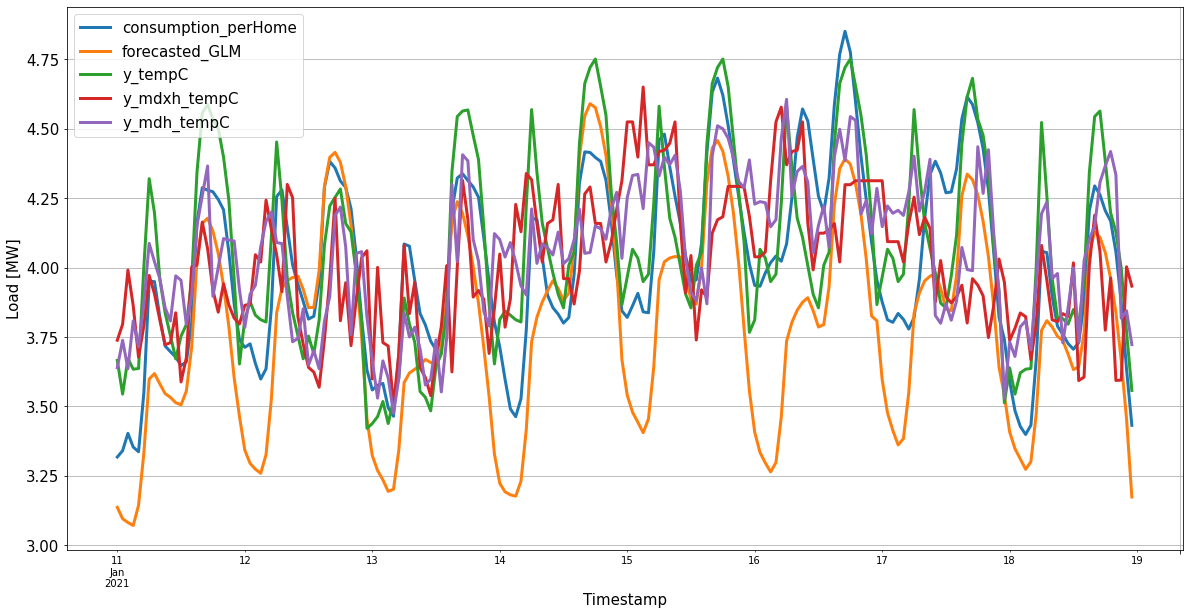

In [39]:
#with temperature as a seperate feature
indices = perHome["2021-1-11": "2021-1-18"].index
perHome.loc[indices].plot(figsize=[20, 10], lw= 3,  legend=True);
ForecastedLoad_home.loc[indices].plot(figsize=[20, 10], lw= 3,  legend=True);
# y_pred_hour.loc[indices].plot(figsize=[20, 10], lw= 3, legend=True);
# y_pred_mdh.loc[indices].plot(figsize=[20, 10], lw= 3 , legend=True);
# y_pred_mdxh.loc[indices].plot(figsize=[20, 10], lw=3,  legend=True);
# y_pred_temp.loc[indices].plot(figsize=[20, 10], lw=3,  legend=True);
# y_pred_trend.loc[indices].plot(figsize=[20, 10], lw=3,  legend=True);
y_pred_tempC.loc[indices].plot(figsize=[20, 10], lw=3,  legend=True);
y_pred_mdxh_tempC.loc[indices].plot(figsize=[20, 10], lw=3,  legend=True);
y_pred_mdh_tempC.loc[indices].plot(figsize=[20, 10], lw=3,  legend=True);
plt.grid()
plt.xticks(fontsize=15), plt.yticks(fontsize=15)
plt.xlabel("Timestamp", fontsize=15), plt.ylabel("Load [MW]", fontsize=15);
plt.legend(fontsize=15);
plt.autoscale()

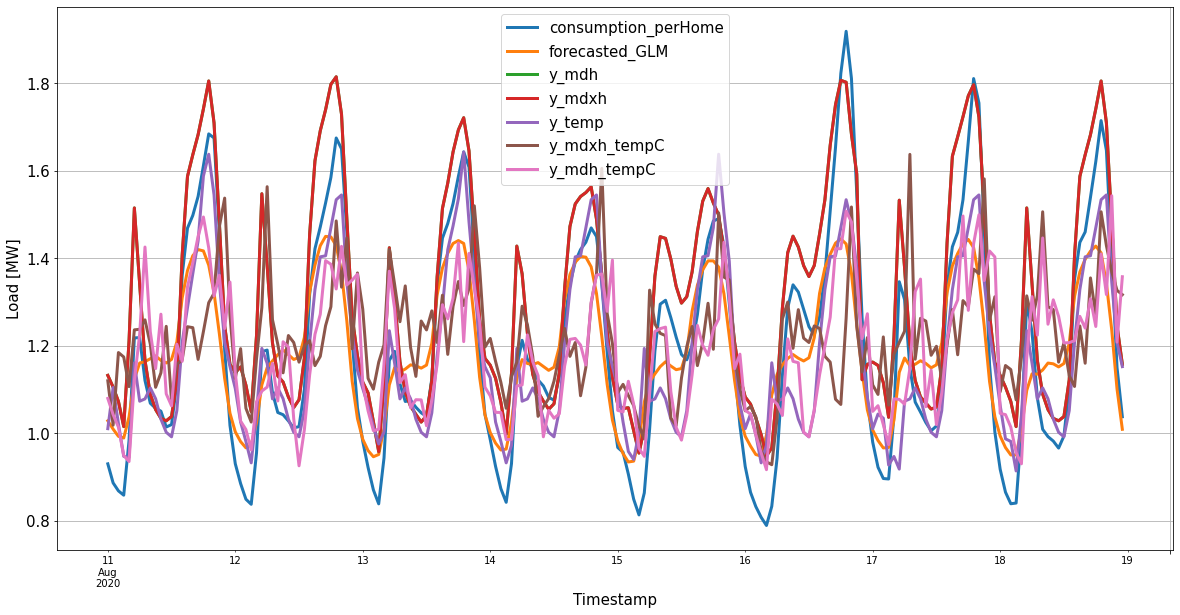

In [45]:
#with temperature as a seperate feature
indices = perHome["2020-8-11": "2020-8-18"].index
perHome.loc[indices].plot(figsize=[20, 10], lw= 3,  legend=True);
ForecastedLoad_home.loc[indices].plot(figsize=[20, 10], lw= 3,  legend=True);
#y_pred_hour.loc[indices].plot(figsize=[20, 10], lw= 3, legend=True);
y_pred_mdh.loc[indices].plot(figsize=[20, 10], lw= 3 , legend=True);
y_pred_mdxh.loc[indices].plot(figsize=[20, 10], lw=3,  legend=True);
y_pred_temp.loc[indices].plot(figsize=[20, 10], lw=3,  legend=True);
#y_pred_trend.loc[indices].plot(figsize=[20, 10], lw=3,  legend=True);
# y_pred_tempC.loc[indices].plot(figsize=[20, 10], lw=3,  legend=True);
y_pred_mdxh_tempC.loc[indices].plot(figsize=[20, 10], lw=3,  legend=True);
y_pred_mdh_tempC.loc[indices].plot(figsize=[20, 10], lw=3,  legend=True);
plt.grid()
plt.xticks(fontsize=15), plt.yticks(fontsize=15)
plt.xlabel("Timestamp", fontsize=15), plt.ylabel("Load [MW]", fontsize=15);
plt.legend(fontsize=15);
plt.autoscale()